# Dynamics on Networks
**Blas Kolic 2025**

In this tutorial, we will implement some of the most famous models for dynamics on networks. We will analyze their behavior under different assumptions, such as their equilibrium distributions, their critical regimes for extended diffusion, and strategies to exploit network structure to maximize or minimize spreading.

First, we will implement each of the models by hand, and visualize them in the Karate club network to gain some intuition. Then, we will move into a slightly larger real network and test different immunization and seeding strategies using epidemiological models of diffusion.

**Outline of the tutorial**
1. **Network dynamics models implementation**: including:
   1. The random walker
   2. Independent cascade model
   3. Epidemiological SIR model
2. **Immunization and seeding strategies**: We will see how to maximize/minimize spread when the dynamics follow the SIR model
3. **Optional exercises**

In [1]:
import numpy as np # numerical operations
import pandas as pd # dataframes and tables
import networkx as nx # networks
import matplotlib.pyplot as plt # visualizations

In [2]:
# Let's take the karate graph with 34 nodes for visualization purposes
G = nx.karate_club_graph()
# Fix node positions to use them in all visualizations
pos = nx.spring_layout(G, seed=42)

G.number_of_nodes(), G.number_of_edges()

(34, 78)

## Implementing the network dynamics models
In each case, we first present the code for simulating the dynamics model for a given network `G`. Then, we present convinient ways of visualizing the dynamic output of such a model, and analyze a little bit of their behavior.

### Random walker

In [3]:
def random_walk(G, start_node, n_steps):
    """
    Random walk on an undirected graph.
    Returns the trajectory (list of visited nodes of length T+1).
    """
    current_node = start_node
    traj = [start_node]

    # Dynamics
    for _ in range(n_steps):
        neighs = list(G.neighbors(current_node))
        current_node = np.random.choice(neighs)        
        traj.append( int(current_node) )
    return traj

In [4]:
# Let's do a first walk!
np.random.seed(0)
initial_node = 10
number_of_steps = 20
walk = random_walk(G, initial_node, number_of_steps)
walk

[10, 0, 31, 33, 8, 32, 33, 14, 33, 26, 33, 15, 33, 19, 0, 10, 0, 12, 3, 0, 2]

In [5]:
# helpers
def visit_frequency(walk):
    return pd.Series(walk).value_counts(normalize=True)

def stationary_dist_rw(G):
    """
    Stationary distribution for a random walk on an undirected graph:
    pi = ki / 2L
    """
    degrees = dict(G.degree())    
    L = G.number_of_edges()
    return {i: degrees[i] / (2*L) for i in G.nodes()}

In [6]:
# Check how frequently each node is visited
visit_frequency(walk)

33    0.238095
0     0.190476
10    0.095238
31    0.047619
8     0.047619
32    0.047619
14    0.047619
26    0.047619
15    0.047619
19    0.047619
12    0.047619
3     0.047619
2     0.047619
Name: proportion, dtype: float64

Let's now visualize the visiting frequency of each node in the random walk in the network.

In [7]:
# network visualization helper
def draw_network_walker(G, walk, stationary_dist=None, pos=None, ax=None):
    """
    Draw nodes colored by `values` (dict node -> value). Start node in red.
    """
    # Get node list and their visit distribution
    nodes = list(G.nodes())
    if stationary_dist is None:
        visit_freqs = visit_frequency(walk)
    else:
        visit_freqs = stationary_dist
    start_node = walk[0]
    # Compute node colors based on frequency
    c_gradient = 12
    node_colors = np.array([c_gradient * visit_freqs.get(i, 0.0) for i in nodes])        

    if pos is None:
        pos = nx.spring_layout(G)

    ## Viz
    # First, edges
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.25, width=1.0)

    # Then, nodes color-coded by visit frequency
    sc = nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_color=node_colors,
        vmin=0, vmax=1, # min and max frequencies
        cmap="viridis",
        node_size=350,
        linewidths=0.5,
        edgecolors="white",
    )

    # Highlight starting node in red
    if stationary_dist is None:
        nx.draw_networkx_nodes(
            G, pos, ax=ax,
            nodelist=[start_node],
            node_color="red",
            node_size=450,
            edgecolors="black",
            linewidths=1.0,
        )

    if ax is None:
        return plt.axis('off')
    else:
        return ax.set_axis_off()

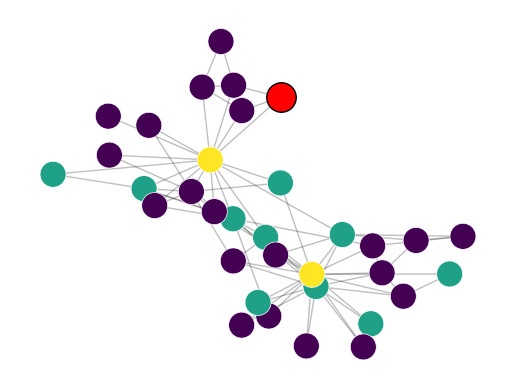

In [8]:
# Red: starting node
# Brigther colors indicate more frequently visited nodes
draw_network_walker(G, walk, pos=pos);

Now, let's take a long random walk and check how the distribution converges into equilibrium

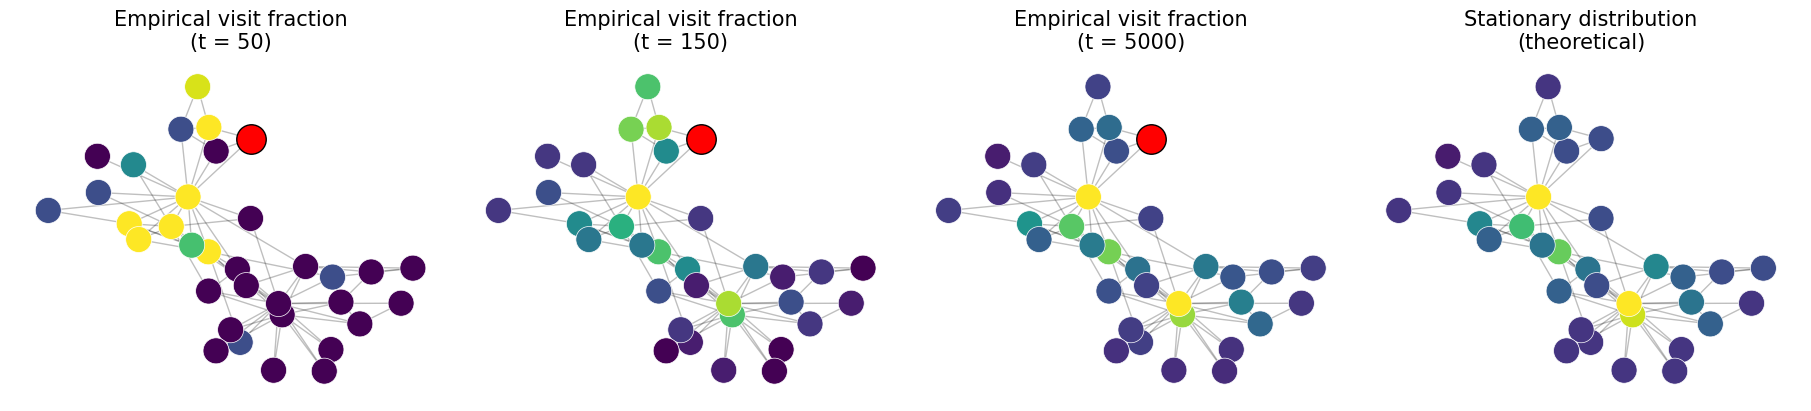

In [9]:
np.random.seed(42) # for reproducibility
start_node = 10 
n_steps = 5000
walk = random_walk(G, start_node, n_steps)
# theoretical equilibrium
stationary_dist = stationary_dist_rw(G) 

## Visualize walk at different timestamps
timestamps = [50, 150, 5000]
fig, ax = plt.subplots(ncols=len(timestamps)+1, figsize=(18, 4), constrained_layout=True)

# Snapshot at each timestamp
for i,t in enumerate(timestamps):
    draw_network_walker(G, walk[:t+1], pos=pos, ax=ax[i])
    ax[i].set_title(f"Empirical visit fraction\n(t = {t})", fontsize=15)
    
# Theoretical equilibrium distribution
draw_network_walker(G, walk, stationary_dist, pos=pos, ax=ax[-1])
ax[-1].set_title(f"Stationary distribution\n(theoretical)", fontsize=15);

We can see how:
- At the beginning, the walk is more *local* in that most visits are closeby to the initial red node
- As time goes by, the visit distribution matches the theoretical one (regardless of the initial node)

### Independent Cascade model

In [10]:
def independent_cascade(G, initial_nodes, p=0.1):
    """
    Independent Cascade (IC) on a (di)graph `G` with homogeneous activation probabilities `p`.
    """

    # Initialize sets of activated nodes
    total_reached = set(initial_nodes)
    currently_active = set(initial_nodes)
    
    # Initialize a list with the activations per step
    activated_per_step = []
    activated_per_step.append(total_reached)
    
    # Dynamics
    while currently_active:    
        # Each active node tries to activate it's non-active neighbors
        new_activations = set()
        for u in currently_active:            
            # Try to activate each neighbor
            for neigh in G.neighbors(u):
                if neigh in total_reached: # if already active, skip
                    continue
                if np.random.rand() < p: # if inactive, try activating with prob p
                    new_activations.add(neigh)

        total_reached = total_reached.union(new_activations)
        currently_active = new_activations # active in step t are the new activations at step t-1

        # Append to the history of activations
        activated_per_step.append( new_activations )

    # Last step is empty, as no new activations occur
    activated_per_step = activated_per_step[:-1]
    return activated_per_step

In [11]:
# Run the independent cascade model for a given initial spreader
np.random.seed(42)
initial_node = [0]
p = 0.3 # activation probability
activations = independent_cascade(G, initial_nodes=initial_node, p=p)
activations

[{0},
 {5, 6, 7, 12, 19, 21, 31},
 {1, 2, 3, 16, 28, 33},
 {9, 13, 14, 26},
 {32},
 {8, 15, 22, 30}]

In [12]:
def draw_network_cascade(G, active_nodes, pos=None, ax=None): #, pos, start, values, title, vmin, vmax):
    """
    Draw network with activated nodes colored in red.
    """
    if pos is None:
        pos = nx.spring_layout(G)

    ## Viz
    # First, edges
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.25, width=1.0)

    # Then, place all nodes
    sc = nx.draw_networkx_nodes(
        G, pos, ax=ax,        
        node_size=350,
        linewidths=0.5,
        edgecolors="white",
    )

    # Finally, highlight nodes in cascade    
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        nodelist=active_nodes,
        node_color="red",
        node_size=450,
        linewidths=1.0,
        edgecolors="white",
    )

    if ax is None:
        return plt.axis('off')
    else:
        return ax.set_axis_off()

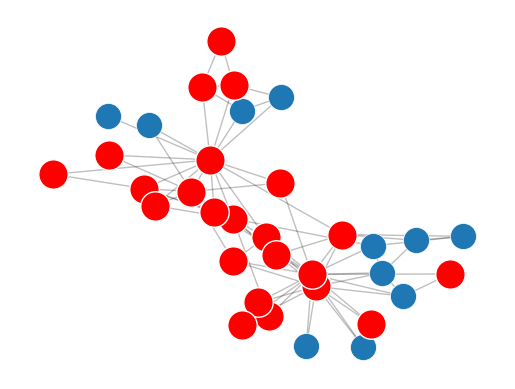

In [13]:
# Visualize cascade in the network

# First, let's join all the nodes that got activated
total_activations = set().union(*activations)
# Now we can plot the network
draw_network_cascade(G, total_activations, pos=pos);

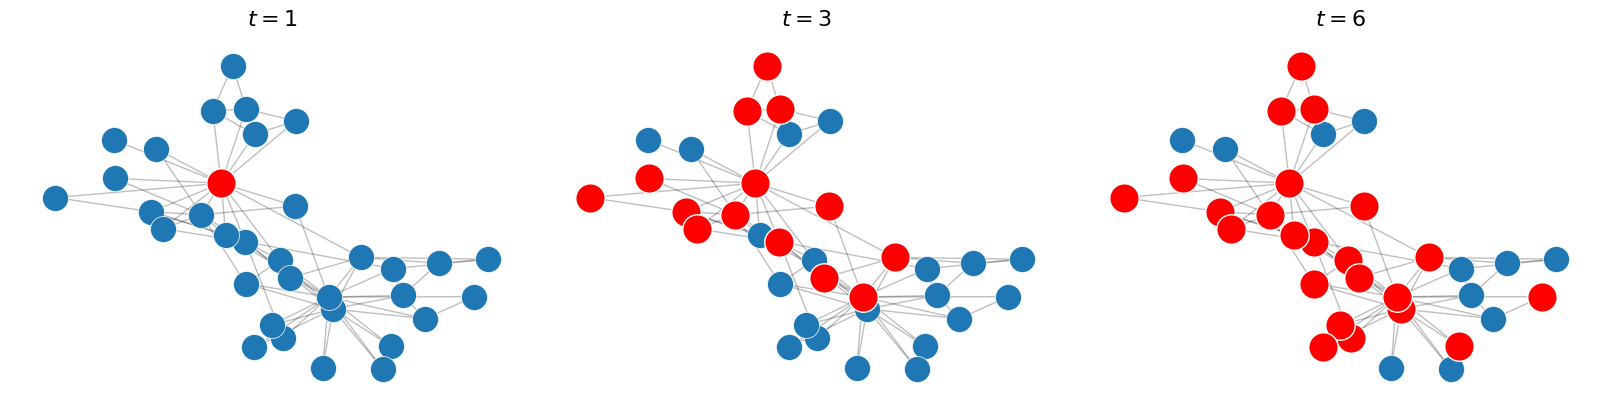

In [14]:
# We can also visualize snapshots of the dynamics
timestamps = [1, 3, len(activations)]

# Viz
fig, ax = plt.subplots(ncols=len(timestamps), figsize=(16, 4), constrained_layout=True)
for i,t in enumerate(timestamps):
    # Get activations up to time t
    activations_until_t = set().union(*activations[:t])
    # Draw network
    draw_network_cascade(G, activations_until_t, pos=pos, ax=ax[i])
    ax[i].set_title(f"$t = {t}$", fontsize=16)

We can observe how, as time goes by, the cascade grows and more and more nodes get activated. Note that not necessarily the cascade ends up covering the whole network.

#### Critical regimes
In the independent cascade model, the reproduction number is given by
$$R_0 = p \langle k \rangle$$
where $p$ is the activation probability and $\langle k \rangle$ the network's average degree.

The critical regime is above and below $R_0 = 1$, meaning that
$$p_c = \frac{1}{\langle k \rangle}$$

Let's see how the cascades look like in each of the regimes.

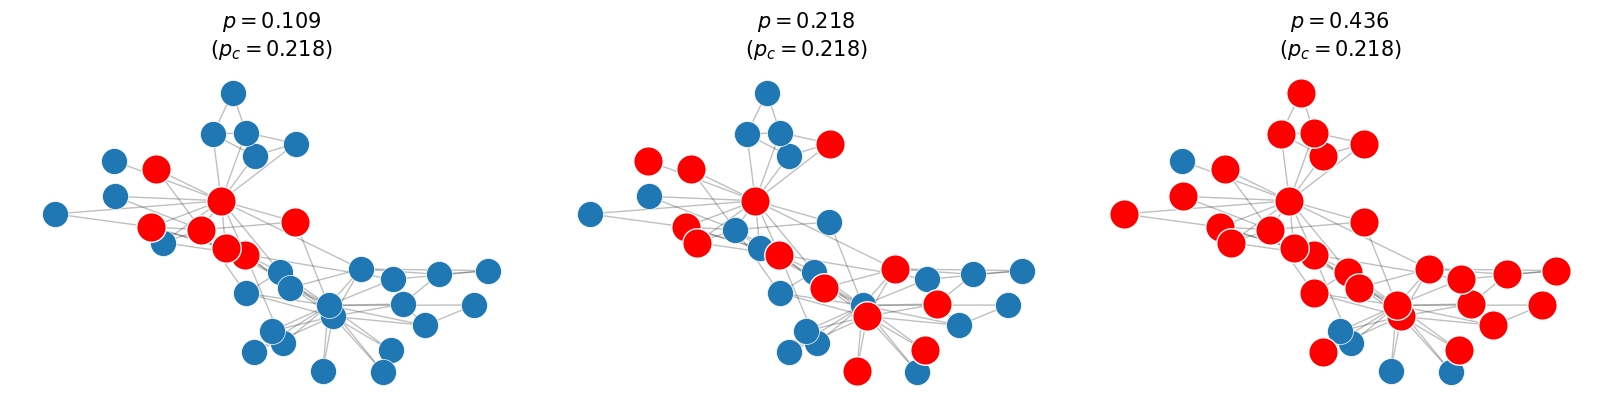

In [15]:
np.random.seed(1) # Change to None to have different realizations
initial_node = [3]

# Consider subcritical, critical, and supercritical contagion probabilities
ks = list( dict(G.degree()).values() )
p_crit = 1/np.mean(ks)
p_low = p_crit/2
p_high = p_crit*2
p_vec = [p_low, p_crit, p_high]

## Viz 
f, ax = plt.subplots(ncols=3, figsize=(16, 4), constrained_layout=True)
for i,p in enumerate(p_vec):
    # Run model
    activations_ic = independent_cascade(G, initial_nodes=[3], p=p)
    # Collect all nodes in cascade
    activated_nodes = set().union(*activations_ic)
    # Plot final cascade
    draw_network_cascade(G, active_nodes=list(activated_nodes), pos=pos, ax=ax[i]);
    ax[i].set_title(f'$p={round(p,3)}$\n$(p_c={round(p_crit,3)})$', fontsize=15)

If you remove the random seed (set `np.random.seed(None)`), you will note that in the critical point, cascades can be very big some times and very small other times, so, around $p_c$, there are *large fluctuations* on the cascades. 

Let's repeat the experiment a bunch of times for below, at, and above $p_c$ and see if we can find clera differences in the cascade sizes.

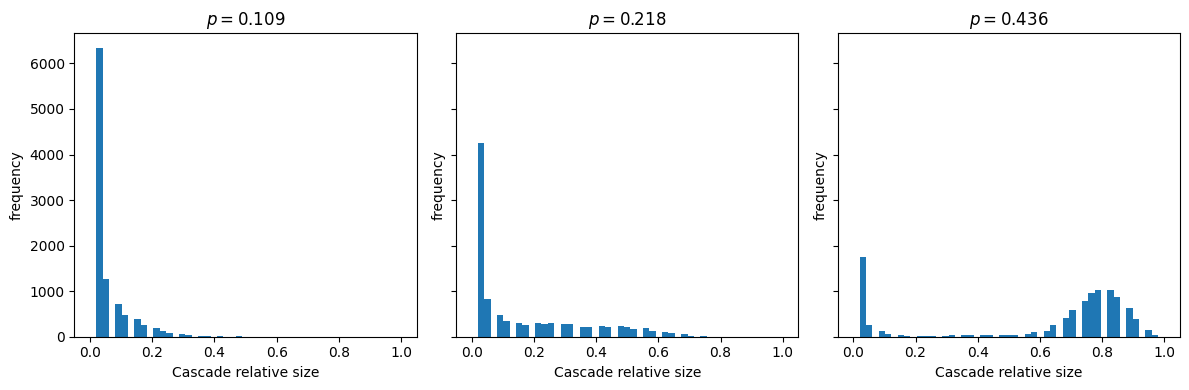

In [16]:
# Re-run the model many times and inspect the cascade size distributions below, at, and above the critical point.
n_reps = 10_000
cascade_sizes = dict()
nodes = list(G.nodes())

for p in p_vec:
    # Create a list of cascade sizes for each activation probablity
    cascade_sizes[p] = []
    
    # Repeat many times
    for _ in range(n_reps):
        # Choose an initial node at random and run the model
        initial_node = np.random.choice( nodes, size=1 )
        activations = independent_cascade(G, initial_nodes=initial_node, p=p)
        # Compute and append cascade sizes (relative to total number of nodes)
        total_activations = set().union(*activations)
        cascade_sizes[p].append( len(total_activations)/len(nodes) ) 

# Visualize for cascade size distribution for each p
f, ax = plt.subplots(ncols=len(p_vec), figsize=(12,4), sharex=True, sharey=True)
bins = np.linspace(0,1, num=50)
for i,p in enumerate(p_vec):
    ax[i].hist( cascade_sizes[p], bins=bins )
    ax[i].set_xlabel('Cascade relative size')
    ax[i].set_ylabel('frequency')
    ax[i].set_title(f'$p={round(p,3)}$')

plt.tight_layout();

In all cases, we find a peak at zero that indicates that the cascade didn't start out. The peak gets smaller as $p$ grows. However, for starting cascades, we observe that:
- Below $p_c$, the cascade size decays very quickly
- At $p_c$, the cascade size has a much broader tail, indicating that there are both small and big cascades at similar proportions
- Above $p_c$, most cascades concentrate around 0.8 or so, indicating that cascades cover most of the network!

### Epidemiological SIR model

In [17]:
def sir_network(G, initial_spreaders, beta=0.2, mu=0.1, n_steps=50):
    """Run SIR model in network `G` with infection rate `beta` and recovery rate `mu`
    Returns list where each element is a dictionary with the state of each node.
    States: S -> susceptible, I -> infected, R -> recovered
    """

    # First, set all nodes as susceptible    
    state = {u: "S" for u in G.nodes()}
    # And infect initial spreaders
    for u in initial_spreaders:
        state[u] = "I"

    # Let infection unfold: at each step, check who recovers and who gets infected
    history = [state.copy()]
    for _ in range(n_steps):
        new_infections = set() 
        new_recoveries = set()

        # Loop through each infected node
        for u, state_prev in state.items():
            # If the node isn't infected, skip            
            if  state_prev!= "I":
                continue

            # infections
            susceptible_neighs = [neigh for neigh in G.neighbors(u) if state[neigh] == 'S']
            for neigh in susceptible_neighs:                
                if np.random.rand() < beta:
                    new_infections.add(neigh)
            # recoveries
            if np.random.rand() < mu: # recover with prob gamma
                new_recoveries.add(u)

        # Update the state
        for v in new_infections:
            state[v] = "I"
        for u in new_recoveries:
            state[u] = "R"
        # Append to the infection history
        history.append(state.copy())        
        # If no one else is infected, the epidemic ends
        if not any(state_prev== "I" for state_prev in state.values()):
            break

    return history

In [18]:
np.random.seed(0)
# First, simulate the epidemic
initial_spreaders = [10]
beta = 0.2 # infection probabilty
mu = 0.1 # recovery probability
history = sir_network(G, initial_spreaders, beta=beta, mu=mu) # looks like [{node: state}_t1, {node: state}_t2, ...]

history[0][0] # step t=0, node 0 -> susceptible

'S'

Again, it would be convenient to visualize the epidemic history in the network itself. So let's create a visualization helper.

In [19]:
# Visualization helper
def draw_network_sir(G, state, pos=None, ax=None):
    """Plots network `G` coloring the nodes according to their `state`"""

    if pos is None:
        pos = nx.spring_layout(G)

    # Assign a color to each of the states
    colors = {"S": "lightgray", "I": "orange", "R": "green"}

    # Viz
    # First, edges
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.25)
    # Finally, draw nodes at each state
    for state_, color in colors.items():
        nodes = [u for u, st in state.items() if st == state_]
        nx.draw_networkx_nodes(
            G, pos, ax=ax,
            nodelist=nodes,
            node_color=color,
            node_size=350,
        )

    if ax is None:
        plt.axis('off')
    else:
        ax.set_axis_off()

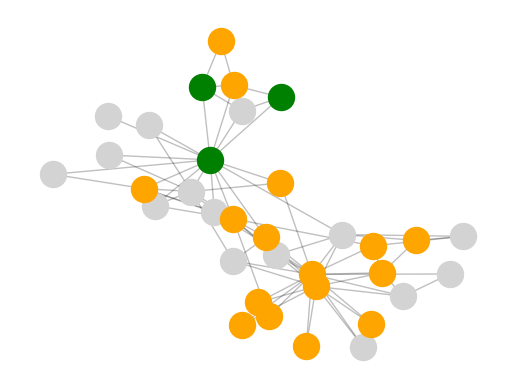

In [20]:
# We can visualize any snapshot of the infection
draw_network_sir(G, history[10], pos=pos)

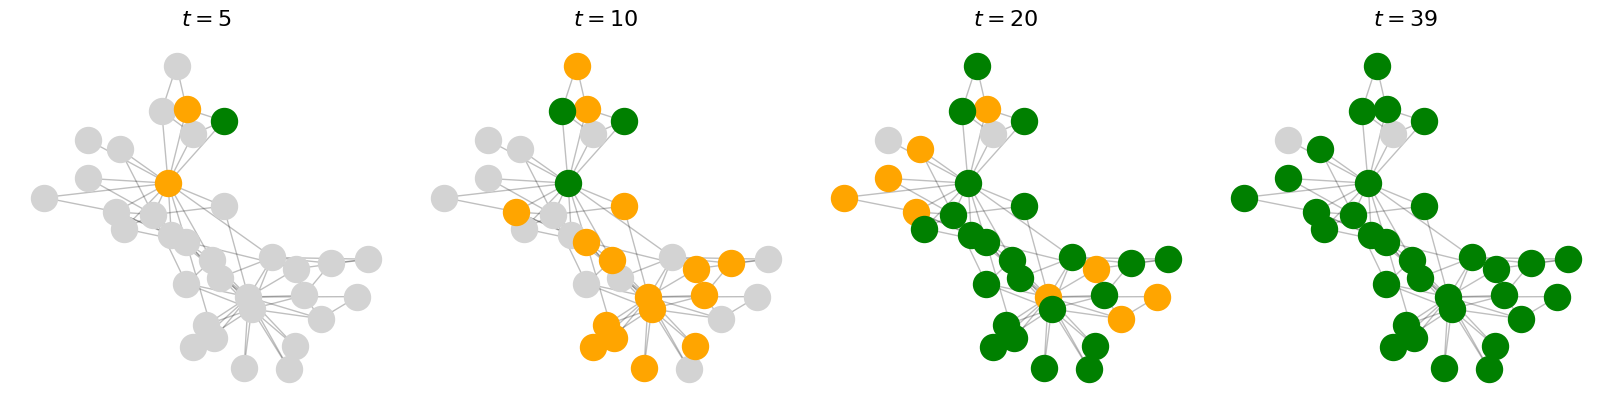

In [21]:
# Let's see how the dynamics unfold
timestamps = [5, 10, 20, len(history)-1]

# Viz
fig, ax = plt.subplots(ncols=len(timestamps), figsize=(16, 4), constrained_layout=True)
for i,t in enumerate(timestamps):
    draw_network_sir(G, history[t], pos=pos, ax=ax[i])
    ax[i].set_title(f"$t = {t}$", fontsize=16)

It is more common to observe the epidemiological curves as *"how many people are infected at day $t$?"*, so let's create a counter that gives us the number of nodes in states S,I,R on each time step.

In [22]:
# helper for counting how many nodes are at what state at each timestep
def get_sir_counts(history):
    """count number of nodes in each state at each time step in `history`"""    
    S = [sum(state == "S" for state in snapshot.values()) for snapshot in history]
    I = [sum(state == "I" for state in snapshot.values()) for snapshot in history]
    R = [sum(state == "R" for state in snapshot.values()) for snapshot in history]
    # Create data frame
    counts = pd.DataFrame([S,I,R]).T
    counts.columns = ['S','I','R']
    return counts

    S  I  R
0  33  1  0
1  33  1  0
2  33  1  0
3  33  1  0
4  32  1  1


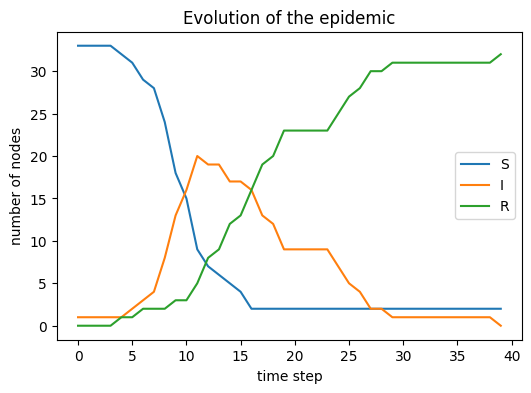

In [24]:
# Then, plot the epidemiological curves
sir_counts = get_sir_counts(history)
print( sir_counts.head() )

sir_counts.plot(figsize=(6,4))
plt.title("Evolution of the epidemic")
plt.xlabel('time step')
plt.ylabel('number of nodes');

At the beginning, most nodes are susceptible. Then, there's a huge peak of infection around $t=12$. Finally, nodes start recovering and the infection fades out.

#### Critical regimes
In the SIR epidemiological model, the reproduction number is given by
$$R_0 = \frac{\beta}{\mu} \frac{\langle k^2 \rangle - \langle k \rangle}{\langle k \rangle}$$
where $\beta$ is the probability that, upon contact, an infected node infects a susceptible contact, and $\mu$ is the recovery rate of incetion.

For $R_0 > 1$ we have exponential growth.

In [25]:
def get_beta_critical(G, mu):
    """Returns critical infectivity"""
    # Get degree sequence
    degree_seq = dict(G.degree()).values()
    degree_seq = np.array(list(degree_seq))
    # Compute beta_c with formula
    k_avg = degree_seq.mean()
    k_sq_avg = (degree_seq**2).mean()
    beta_c = mu * k_avg / (k_sq_avg - k_avg)
    return beta_c

In [26]:
%%time
## Compute critical infectivity
beta_c = get_beta_critical(G, mu)
print(f"beta_c = {round(beta_c,3)}")

## Simulate the epidemic many times for many values of beta
np.random.seed(42)
betas = np.linspace(0,0.3, num=100)
n_reps = 50

num_infected_vec = dict()
for beta in betas:
    num_infected_vec[beta] = []
    for _ in range(n_reps):
        # Run model 
        initial_spreaders = np.random.choice(G.nodes(), size=1)
        history = sir_network(G, initial_spreaders, beta=beta, mu=mu)
        # Collect the number of infected
        sir_counts = get_sir_counts(history)
        total_infected = sir_counts['R'].values[-1] # everyone that recovered got infected at some point.
        
        # Append results
        num_infected_vec[beta].append( total_infected )

beta_c = 0.015
CPU times: user 2.62 s, sys: 54.9 ms, total: 2.67 s
Wall time: 2.67 s


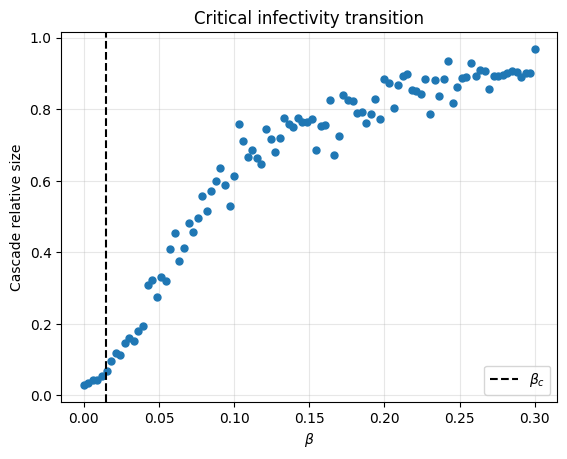

In [27]:
# Create a dataframe and get average cascade size
num_infected_avg = pd.DataFrame(num_infected_vec).mean()
num_infected_avg = num_infected_avg/G.number_of_nodes() # noramlize by number of nodes
# Plot beta vs relative cascade size
num_infected_avg.plot(linewidth=0, marker='o', markersize=5, label='')
plt.axvline(beta_c, color='k', ls='--', label='$\\beta_c$')
plt.legend()
plt.title("Critical infectivity transition")
plt.ylabel("Cascade relative size")
plt.xlabel("$\\beta$")
plt.grid(alpha=0.3);

Observe the critical transition below and above $\beta_c$. Below it, there is practiaclly no spread through the network. Above it, the cascade size rises quickly up to a point where most of the network gets infected (at $\beta \approx 0.25$).

## Immunization and Seeding strategies
In this part, we will test the strategies we saw in class to either minimize or maximize the spread of an epidemic. 

To do so, we will use a real social network of friendships in Uganda, where nodes are households and edges represent close friendships between them. The network is available at the [Netzschleuder network repository](https://networks.skewed.de/net/ugandan_village), where I picked network `friendship-8`.

The [original paper](https://www.pnas.org/doi/full/10.1073/pnas.1700166114) talks about fragmentation in social networks. If interested, see here:
> Chami, Goylette F., et al. "Social network fragmentation and community health." Proceedings of the National Academy of Sciences 114.36 (2017): E7425-E7431.

In [28]:
edgelist = pd.read_csv('data/friendships_uganda/edges.csv')
edgelist = edgelist[ edgelist['source'] != edgelist['target'] ] # remove self-edges
G = nx.from_pandas_edgelist(edgelist, create_using=nx.Graph)

G.number_of_nodes(), G.number_of_edges()

(369, 1753)

In [29]:
# First, let's compute beta_c
mu = 0.1
beta_c = get_beta_critical(G, mu)
print(f"beta_c = {round(beta_c,3)}")

beta_c = 0.008


In [30]:
# Let's choose a beta (infectivity) higher than beta_c
beta = 0.1

#### Immunization
Vaccinating/immunizing nodes is equivalent to removing them. Let's do that for the two startegies we saw in class:
1. **Random vaccination**: Remove a proportion $g$ of nodes at random
2. **Targeted vaccination**: Remove a proportion $g$ of nodes from highest to lowest degree

Let's check if targeted vaccination has any effect.

In [31]:
np.random.seed(0)
# Let's vaccinate 20% of the population
g = 0.2
n_removed = int(g * G.number_of_nodes())
nodes = G.nodes
print(f"We will remove a fraction {g=} of nodes")

# Random vaccination
nodes_random = set( np.random.choice( nodes, size=n_removed, replace=False ) )
G_random = G.subgraph( set(nodes).difference(nodes_random) )

# Targeted vaccination
degrees = sorted(G.degree, key=lambda x: x[1], reverse=True) # descending
nodes_targeted = [n for n, _ in degrees[:n_removed]]
G_targeted = G.subgraph( set(nodes).difference(nodes_targeted) )

We will remove a fraction g=0.2 of nodes


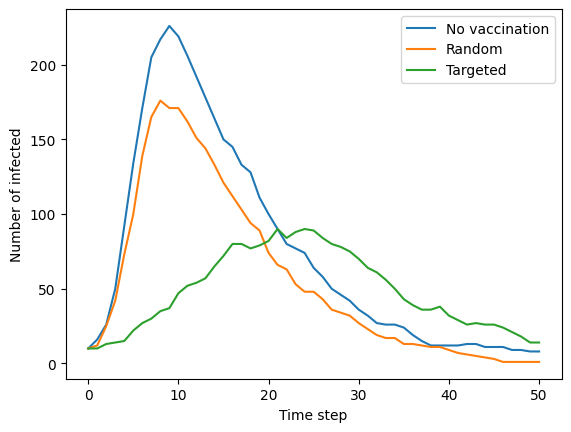

In [32]:
np.random.seed(0)
## Now, run the model on each of the vaccinated networks
# Choose initial spreaders
nodes_remaining = set(nodes).difference(nodes_random).difference(nodes_targeted)
initial_spreaders = np.random.choice(list(nodes_remaining), size=10)

# Run for each case
history = sir_network(G, initial_spreaders, beta=beta, mu=mu)
history_random = sir_network(G_random, initial_spreaders, beta=beta, mu=mu)
history_targeted = sir_network(G_targeted, initial_spreaders, beta=beta, mu=mu)

# Plot number of infections
get_sir_counts(history)["I"].plot(label='No vaccination')
get_sir_counts(history_random)["I"].plot(label='Random')
get_sir_counts(history_targeted)['I'].plot(label='Targeted')
plt.ylabel("Number of infected")
plt.xlabel("Time step")
plt.legend();

- With no vaccination, the infection peak has ~250 infected nodes at the same time
- With random vaccination, the peak reduces to ~170 simulatenous infections
- With targeted vaccination, it further reduces to ~100 simulatenous infections.

Following good immunization strategies, we were able to **flatten the curve!**

#### Sensors & seeding
Now let's try to detect early and fast spreaders. We can do this by detecting important nodes in the network and start a diffusion process with them.

So far, we have followed a *random seeding* strategy, where we start with $10$ initial spreaders. However, for strategic seeding, we will choose those with the highest X and see if how it changes the infection dynamics.

In [33]:
np.random.seed(0) # reproducibility
n_seeders = 5

# Random seeding
initial_spreaders_random = np.random.choice(G.nodes, size=n_seeders)

# Targeted seeding
# centrality_degree = nx.degree_centrality(G)
centrality_degree = nx.degree_centrality(G)
centrality_degree = dict(sorted(centrality_degree.items(), key=lambda x: x[1], reverse=True))
initial_spreaders_targeted = list( centrality_degree.keys() )[:n_seeders]

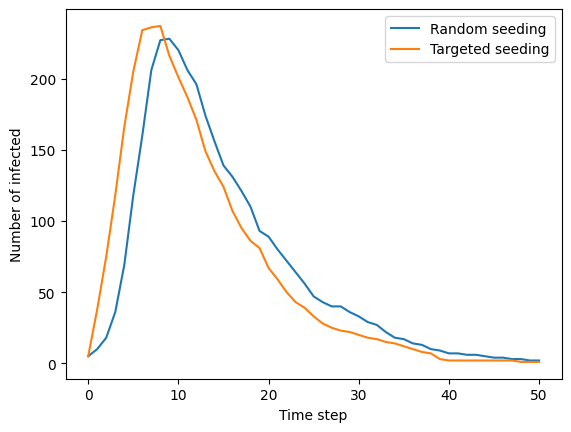

In [34]:
np.random.seed(0) # reproducibility
# Run for each case
history_random = sir_network(G, initial_spreaders_random, beta=beta, mu=mu)
history_targeted = sir_network(G, initial_spreaders_targeted, beta=beta, mu=mu)

# Plot number of infections
get_sir_counts(history_random)["I"].plot(label='Random seeding')
get_sir_counts(history_targeted)['I'].plot(label='Targeted seeding')
plt.ylabel("Number of infected")
plt.xlabel("Time step")
plt.legend();

We can see how with targeted seeding, the infection peak comes before, given that high-degree nodes reach the rest of the network much faster than random nodes. However, the height of the peak is practically the same than with random seeding.

## Excercises (Optional)
1. **Reproduction number.** We have seen how vaccinating the population decreases the infection rate of the epidemic. Let's quantify how much.
   1. What's the basic reproduction number $R_0$ of 1) the network without vaccination, 2) the network with random vaccination, 3) the network with targeted vaccination.
   2. Find the critical proportion of the population $g_c$ that should be vaccinated in order to set $R_0$ below 1.
2. **Exploring more strategies.** Targeted immunization and seeding rely on finding high-degree nodes. However, there might be other ways to detect important nodes that help us minimize or maximize the spread even better than the degree. What other strategies can you think about? Try them! Are they better, worse or equal than using the degree?